In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import decoupler as dc
import sc_toolbox
import random
import seaborn.objects as so

In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]

In [3]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
%%R

.libPaths(c(paste0("/well/immune-rep/users/vbw431/python/scvi_new_ivy/r_modules"), .libPaths()))

library(tidyverse)
library(parallel)
library(Seurat)
library(scater)


cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [5]:
%%R
peppa <- readRDS(paste0(out.dir, "/peppa_pbmc_all.rds"))

##filter pre vaccination samples and pre treatment samples out
peppa <- subset(peppa, subset = Treatment_status != "Pre_treatment")

trim_barcodes <- peppa@meta.data %>% 
  select(orig.ident) %>%
  filter(grepl("_0|SeuratProject", orig.ident))
table(trim_barcodes)

peppa <- subset(peppa, cells = rownames(trim_barcodes))

peppa <- peppa %>% Seurat::NormalizeData() %>% ScaleData()


In [12]:
%%R
library(CellChat)
adata_all.obs["celltype_consensus"] = adata_all.obs["celltype_consensus.l1"].astype("str").copy()

adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['cDC1', 
                                                                                 'cDC2', 
                                                                                 'pDC', 
                                                                                 'ASDC'])]='Dendritic'

adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['ncMono'])]='ncMono'
adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['cMono'])]='cMono'
adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['HSPC'])]='HSPC'

adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['HSPC'])]='HSPC'

adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['CD4.Mitohi',
                                                                                 'CD4.Naive',
                                                                                 'CD4.TCM',
                                                                                 'CD4.TEM',
                                                                                 'CD4.TEMRA', 
                                                                                 'dnT'])]='CD4'
adata_all.obs["celltype_consensus"][adata_all.obs["celltype_consensus.l2"].isin(['CD8.Naive',
                                                                                 'CD8.TCM',
                                                                                 'CD8.TEM',
                                                                                 'CD8.TEMRA',
                                                                                'MPECs',
                                                                                'MAIT',
                                                                                'gdT'])]='CD8'




In [143]:
%%R
peppa@meta.data <- peppa@meta.data %>%
mutate(celltype_consensus = ifelse(grepl("DC1|DC2|pDC|ASDC", celltype_consensus.l2), "Dendritic",
                                ifelse(grepl("Treg", celltype_consensus.l2), "CD4 T regulatory cells", 
                                  ifelse(grepl("CD4", celltype_consensus.l2), "CD4 T cells", 
                                        ifelse(grepl("CD8|MPEC", celltype_consensus.l2), "CD8 T cells",
                                              ifelse(grepl("^Plasma", celltype_consensus.l2), "Plasmablasts",
                                                    ifelse(grepl("^B.", celltype_consensus.l2), "B cells",
                                                           ifelse(grepl("^NK.", celltype_consensus.l2), "NK cells",
                                                          celltype_consensus.l2))))))))
       
peppa@meta.data$celltype_consensus %>% unique()

 [1] "NK cells"               "CD8 T cells"            "gdT"                   
 [4] "MAIT"                   "CD4 T cells"            "CD4 T regulatory cells"
 [7] "dnT"                    "B cells"                "cMono"                 
[10] "ncMono"                 "Dendritic"              "HSPC"                  


In [144]:
%%R

##analysis for pre-vaccine and on treatment samples only
peppa_list <- SplitObject(peppa, split.by = "study_disease")


names <- names(peppa_list)

cellchat_list <- lapply(names, function(x){
  data.input <- GetAssayData(peppa_list[[x]], assay = "RNA", slot = "data") # normalized data matrix
  Idents(peppa_list[[x]]) <- "celltype_consensus"
  labels <- Idents(peppa_list[[x]])
  meta <- data.frame(labels = labels, row.names = names(labels)) # create a dataframe of the cell labels
  cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels")
  cellchat <- addMeta(cellchat, meta = meta, meta.name = "labels")
  cellchat <- setIdent(cellchat, ident.use = "labels") # set "labels" as default cell identity
  return(cellchat)
})
names(cellchat_list) <- names


##set database
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
dplyr::glimpse(CellChatDB$interaction)
CellChatDB.use <- CellChatDB # simply use the default CellChatDB

#future::plan("multiprocess", workers = 8) # do parallel

names <- names(cellchat_list)
cellchat_list <- lapply(names, function(x){
  cellchat_list[[x]]@DB <- CellChatDB.use
  cellchat_list[[x]] <- subsetData(cellchat_list[[x]])
  return(cellchat_list[[x]] )
  })

names(cellchat_list) <- names


[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  NK cells CD8 T cells gdT MAIT CD4 T cells CD4 T regulatory cells dnT B cells cMono ncMono Dendritic HSPC 
[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  NK cells CD8 T cells MAIT gdT CD4 T cells dnT CD4 T regulatory cells B cells cMono ncMono Dendritic HSPC 
[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  NK cells CD8 T cells MAIT gdT CD4 T cells CD4 T regulatory cells dnT B cells ncMono cMono Dendritic HSPC 
Rows: 1,939
Columns: 11
$ interaction_name   <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2", "TGFB~
$ pathway_name       <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TG~
$ ligand             <chr> "TGFB1", "TGFB2", "TGFB3", "TG

In [146]:
%%R
table(peppa@meta.data %>% select(study_disease, celltype_consensus)) %>% print()

             celltype_consensus
study_disease B cells CD4 T cells CD4 T regulatory cells CD8 T cells Dendritic
      CTRL       4884       18445                   1345       13694      1055
      HBV        6979       13784                    636        8292      1067
      HBV_HIV    3022        8934                    415        9983       545
             celltype_consensus
study_disease  HSPC  MAIT NK cells cMono   dnT   gdT ncMono
      CTRL      162  1015     4945 13122   672   771   1339
      HBV        99   370     8225  8462   484  1104   3081
      HBV_HIV    45   200     3993  6570   276   210    997


In [147]:
%%R

new_cellchat_list <- lapply(names(cellchat_list), function(x){
  print("identifyOverExpressedGenes")
  cellchat_list[[x]] <- identifyOverExpressedGenes(cellchat_list[[x]])
  print("identifyOverExpressedInteractions")
  cellchat_list[[x]] <- identifyOverExpressedInteractions(cellchat_list[[x]])
  z <- projectData(cellchat_list[[x]], PPI.human)
  # Calculate communication probability and network
  print("computeCommunProb")
  cellchat_list[[x]] <- computeCommunProb(cellchat_list[[x]])
  print("computeCommunProbPathway")
  cellchat_list[[x]] <- computeCommunProbPathway(cellchat_list[[x]])
  print("aggregateNet")
  cellchat_list[[x]] <- aggregateNet(cellchat_list[[x]])
  print("netAnalysis_computeCentrality")
  cellchat_list[[x]] <- netAnalysis_computeCentrality(cellchat_list[[x]], slot.name = "netP")
  saveRDS(cellchat_list[[x]], file = paste0(out.dir,"/cellchat/", x,"_cellchat_l1.rds"))
  return(cellchat_list[[x]])
})



[1] "identifyOverExpressedGenes"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~20s           |++                                                | 3 % ~21s           |+++                                               | 4 % ~19s           |+++                                               | 6 % ~18s           |++++                                              | 7 % ~18s           |+++++                                             | 9 % ~17s           |+++++                                             | 10% ~17s           |++++++                                            | 11% ~17s           |+++++++                                           | 13% ~17s           |++++++++                                          | 14% ~16s           |++++++++                                          | 16% ~16s           |+++++++++                                         | 17% ~16s           |++++++++++                  

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~19s           |++                                                | 3 % ~17s           |+++                                               | 4 % ~17s           |+++                                               | 6 % ~16s           |++++                                              | 7 % ~16s           |+++++                                             | 9 % ~16s           |++++++                                            | 10% ~16s           |++++++                                            | 12% ~17s           |+++++++                                           | 13% ~17s           |++++++++                                          | 14% ~16s           |++++++++                                          | 16% ~16s           |+++++++++                                         | 17% ~16s           |++++++++++                                        | 19% ~15s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~18s           |++                                                | 2 % ~18s           |++                                                | 3 % ~16s           |+++                                               | 4 % ~17s           |+++                                               | 5 % ~16s           |++++                                              | 6 % ~15s           |++++                                              | 7 % ~15s           |+++++                                             | 8 % ~14s           |+++++                                             | 9 % ~15s           |++++++                                            | 11% ~15s           |++++++                                            | 12% ~14s           |+++++++                                           | 13% ~14s           |+++++++                                           | 14% ~15s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~15s           |++                                                | 2 % ~15s           |++                                                | 3 % ~15s           |+++                                               | 4 % ~16s           |+++                                               | 5 % ~15s           |++++                                              | 6 % ~15s           |++++                                              | 7 % ~15s           |+++++                                             | 8 % ~15s           |+++++                                             | 9 % ~15s           |++++++                                            | 10% ~15s           |++++++                                            | 11% ~14s           |+++++++                                           | 12% ~15s           |+++++++                                           | 13% ~15s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~15s           |++                                                | 2 % ~15s           |++                                                | 3 % ~14s           |+++                                               | 4 % ~14s           |+++                                               | 5 % ~14s           |++++                                              | 6 % ~14s           |++++                                              | 7 % ~14s           |+++++                                             | 8 % ~14s           |+++++                                             | 9 % ~14s           |++++++                                            | 11% ~14s           |++++++                                            | 12% ~14s           |+++++++                                           | 13% ~14s           |+++++++                                           | 14% ~14s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~15s           |++                                                | 3 % ~15s           |+++                                               | 4 % ~14s           |+++                                               | 6 % ~15s           |++++                                              | 7 % ~14s           |+++++                                             | 9 % ~14s           |++++++                                            | 10% ~14s           |++++++                                            | 12% ~14s           |+++++++                                           | 13% ~14s           |++++++++                                          | 15% ~15s           |+++++++++                                         | 16% ~14s           |+++++++++                                         | 18% ~14s           |++++++++++                                        | 19% ~14s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~17s           |++                                                | 2 % ~16s           |++                                                | 3 % ~16s           |+++                                               | 4 % ~16s           |+++                                               | 5 % ~15s           |++++                                              | 6 % ~15s           |++++                                              | 7 % ~15s           |+++++                                             | 8 % ~15s           |+++++                                             | 9 % ~15s           |++++++                                            | 10% ~15s           |++++++                                            | 11% ~14s           |+++++++                                           | 12% ~14s           |+++++++                                           | 13% ~14s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~14s           |++                                                | 2 % ~14s           |++                                                | 3 % ~14s           |+++                                               | 5 % ~14s           |+++                                               | 6 % ~13s           |++++                                              | 7 % ~13s           |+++++                                             | 8 % ~13s           |+++++                                             | 9 % ~13s           |++++++                                            | 10% ~13s           |++++++                                            | 11% ~13s           |+++++++                                           | 13% ~13s           |+++++++                                           | 14% ~13s           |++++++++                                          | 15% ~13s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~24s           |++                                                | 2 % ~26s           |++                                                | 4 % ~25s           |+++                                               | 5 % ~24s           |++++                                              | 6 % ~24s           |++++                                              | 7 % ~24s           |+++++                                             | 9 % ~23s           |+++++                                             | 10% ~23s           |++++++                                            | 11% ~23s           |+++++++                                           | 12% ~23s           |+++++++                                           | 14% ~23s           |++++++++                                          | 15% ~22s           |+++++++++                                         | 16% ~22s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~18s           |++                                                | 2 % ~18s           |++                                                | 4 % ~20s           |+++                                               | 5 % ~19s           |++++                                              | 6 % ~19s           |++++                                              | 8 % ~19s           |+++++                                             | 9 % ~18s           |+++++                                             | 10% ~18s           |++++++                                            | 11% ~18s           |+++++++                                           | 12% ~18s           |+++++++                                           | 14% ~17s           |++++++++                                          | 15% ~17s           |+++++++++                                         | 16% ~17s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~25s           |++                                                | 2 % ~24s           |++                                                | 3 % ~25s           |+++                                               | 4 % ~24s           |+++                                               | 5 % ~24s           |++++                                              | 6 % ~24s           |++++                                              | 7 % ~24s           |+++++                                             | 8 % ~23s           |+++++                                             | 9 % ~23s           |++++++                                            | 10% ~22s           |++++++                                            | 11% ~23s           |+++++++                                           | 12% ~22s           |+++++++                                           | 13% ~22s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~15s           |++                                                | 3 % ~16s           |+++                                               | 4 % ~17s           |+++                                               | 6 % ~17s           |++++                                              | 7 % ~17s           |+++++                                             | 8 % ~16s           |+++++                                             | 10% ~16s           |++++++                                            | 11% ~16s           |+++++++                                           | 13% ~15s           |++++++++                                          | 14% ~15s           |++++++++                                          | 15% ~15s           |+++++++++                                         | 17% ~14s           |++++++++++                                        | 18% ~14s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 13% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01s           |+++                                               | 6 % ~01s           |+++++                                             | 8 % ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 14% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s           |++++++++++++                                      | 22% ~01s           |+++++++++++++                                     | 25% ~01s           |++++++++++++++                                    | 28% ~01s           |++++++++++++++++                                  | 31% ~01s           |+++++++++++++++++                                 | 33% ~01s           |+++++++++++++++++++                               | 36% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 2 % ~10s           |++                                                | 3 % ~11s           |+++                                               | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 7 % ~09s           |+++++                                             | 8 % ~09s           |+++++                                             | 9 % ~09s           |++++++                                            | 10% ~09s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~09s           |+++++++                                           | 13% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 2 % ~10s           |++                                                | 3 % ~10s           |+++                                               | 4 % ~09s           |+++                                               | 5 % ~09s           |++++                                              | 6 % ~09s           |++++                                              | 7 % ~09s           |+++++                                             | 8 % ~09s           |+++++                                             | 9 % ~09s           |++++++                                            | 10% ~09s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~09s           |+++++++                                           | 13% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~07s           |++                                                | 3 % ~07s           |++                                                | 4 % ~07s           |+++                                               | 5 % ~07s           |++++                                              | 6 % ~07s           |++++                                              | 8 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 10% ~07s           |++++++                                            | 12% ~07s           |+++++++                                           | 13% ~07s           |++++++++                                          | 14% ~07s           |++++++++                                          | 16% ~07s           |+++++++++                                         | 17% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 2 % ~08s           |++                                                | 4 % ~08s           |+++                                               | 5 % ~08s           |++++                                              | 6 % ~08s           |++++                                              | 8 % ~08s           |+++++                                             | 9 % ~07s           |+++++                                             | 10% ~07s           |++++++                                            | 11% ~07s           |+++++++                                           | 12% ~07s           |+++++++                                           | 14% ~07s           |++++++++                                          | 15% ~07s           |+++++++++                                         | 16% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10s           |++                                                | 2 % ~10s           |++                                                | 3 % ~09s           |+++                                               | 4 % ~09s           |+++                                               | 5 % ~09s           |++++                                              | 6 % ~09s           |++++                                              | 7 % ~09s           |+++++                                             | 8 % ~08s           |+++++                                             | 9 % ~08s           |++++++                                            | 10% ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 2 % ~08s           |++                                                | 4 % ~07s           |+++                                               | 5 % ~07s           |+++                                               | 6 % ~07s           |++++                                              | 7 % ~07s           |+++++                                             | 8 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 11% ~07s           |++++++                                            | 12% ~07s           |+++++++                                           | 13% ~07s           |++++++++                                          | 14% ~07s           |++++++++                                          | 15% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 2 % ~08s           |++                                                | 3 % ~08s           |+++                                               | 5 % ~08s           |+++                                               | 6 % ~08s           |++++                                              | 7 % ~08s           |+++++                                             | 8 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 10% ~07s           |++++++                                            | 11% ~07s           |+++++++                                           | 13% ~07s           |+++++++                                           | 14% ~07s           |++++++++                                          | 15% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10s           |++                                                | 2 % ~09s           |++                                                | 3 % ~08s           |+++                                               | 4 % ~08s           |+++                                               | 6 % ~08s           |++++                                              | 7 % ~08s           |++++                                              | 8 % ~08s           |+++++                                             | 9 % ~07s           |+++++                                             | 10% ~07s           |++++++                                            | 11% ~07s           |+++++++                                           | 12% ~07s           |+++++++                                           | 13% ~07s           |++++++++                                          | 14% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~13s           |++                                                | 3 % ~12s           |+++                                               | 5 % ~12s           |+++                                               | 6 % ~12s           |++++                                              | 7 % ~12s           |+++++                                             | 8 % ~11s           |+++++                                             | 9 % ~11s           |++++++                                            | 10% ~11s           |++++++                                            | 11% ~11s           |+++++++                                           | 13% ~11s           |+++++++                                           | 14% ~10s           |++++++++                                          | 15% ~10s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 3 % ~09s           |+++                                               | 4 % ~09s           |+++                                               | 6 % ~09s           |++++                                              | 7 % ~09s           |+++++                                             | 8 % ~08s           |+++++                                             | 10% ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 13% ~08s           |++++++++                                          | 14% ~08s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 17% ~09s           |++++++++++                                        | 18% ~08s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~12s           |++                                                | 3 % ~12s           |+++                                               | 4 % ~12s           |+++                                               | 6 % ~12s           |++++                                              | 7 % ~12s           |++++                                              | 8 % ~12s           |+++++                                             | 9 % ~12s           |+++++                                             | 10% ~11s           |++++++                                            | 11% ~11s           |+++++++                                           | 12% ~11s           |+++++++                                           | 13% ~11s           |++++++++                                          | 14% ~11s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~07s           |++                                                | 3 % ~07s           |+++                                               | 4 % ~06s           |+++                                               | 6 % ~06s           |++++                                              | 7 % ~06s           |+++++                                             | 8 % ~06s           |+++++                                             | 10% ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 12% ~06s           |+++++++                                           | 14% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 17% ~06s           |++++++++++                                        | 18% ~06s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 13% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~01s           |++++                                              | 7 % ~01s           |++++++                                            | 11% ~01s           |++++++++                                          | 15% ~01s           |++++++++++                                        | 19% ~01s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 26% ~00s           |+++++++++++++++                                   | 30% ~01s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 37% ~00s           |+++++++++++++++++++++                             | 41% ~00s           |+++++++++++++++++++++++                           | 44% ~00s           |+++++++++++++++++++++++++                         | 48% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~14s           |++                                                | 2 % ~13s           |++                                                | 3 % ~14s           |+++                                               | 5 % ~13s           |+++                                               | 6 % ~13s           |++++                                              | 7 % ~12s           |++++                                              | 8 % ~12s           |+++++                                             | 9 % ~12s           |++++++                                            | 10% ~12s           |++++++                                            | 11% ~12s           |+++++++                                           | 12% ~12s           |+++++++                                           | 14% ~12s           |++++++++                                          | 15% ~12s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~12s           |++                                                | 3 % ~12s           |+++                                               | 4 % ~12s           |+++                                               | 5 % ~12s           |++++                                              | 7 % ~12s           |++++                                              | 8 % ~12s           |+++++                                             | 9 % ~12s           |+++++                                             | 10% ~12s           |++++++                                            | 11% ~12s           |+++++++                                           | 12% ~12s           |+++++++                                           | 13% ~12s           |++++++++                                          | 14% ~12s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 2 % ~12s           |++                                                | 3 % ~13s           |+++                                               | 5 % ~13s           |+++                                               | 6 % ~12s           |++++                                              | 7 % ~12s           |+++++                                             | 8 % ~12s           |+++++                                             | 9 % ~12s           |++++++                                            | 10% ~11s           |++++++                                            | 12% ~11s           |+++++++                                           | 13% ~11s           |+++++++                                           | 14% ~11s           |++++++++                                          | 15% ~11s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~15s           |++                                                | 2 % ~15s           |++                                                | 3 % ~14s           |+++                                               | 4 % ~13s           |+++                                               | 5 % ~13s           |++++                                              | 6 % ~13s           |++++                                              | 7 % ~13s           |+++++                                             | 8 % ~13s           |+++++                                             | 9 % ~13s           |++++++                                            | 11% ~12s           |++++++                                            | 12% ~13s           |+++++++                                           | 13% ~12s           |+++++++                                           | 14% ~12s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~12s           |++                                                | 3 % ~12s           |+++                                               | 4 % ~13s           |+++                                               | 5 % ~13s           |++++                                              | 6 % ~13s           |++++                                              | 7 % ~12s           |+++++                                             | 8 % ~12s           |+++++                                             | 9 % ~12s           |++++++                                            | 10% ~12s           |++++++                                            | 11% ~12s           |+++++++                                           | 12% ~12s           |+++++++                                           | 14% ~11s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 2 % ~10s           |++                                                | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 7 % ~10s           |+++++                                             | 8 % ~10s           |+++++                                             | 10% ~10s           |++++++                                            | 11% ~10s           |+++++++                                           | 12% ~10s           |+++++++                                           | 13% ~10s           |++++++++                                          | 14% ~10s           |++++++++                                          | 16% ~10s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~12s           |++                                                | 3 % ~12s           |+++                                               | 4 % ~12s           |+++                                               | 5 % ~12s           |++++                                              | 6 % ~12s           |++++                                              | 7 % ~12s           |+++++                                             | 8 % ~13s           |+++++                                             | 9 % ~13s           |++++++                                            | 10% ~12s           |++++++                                            | 11% ~12s           |+++++++                                           | 12% ~12s           |+++++++                                           | 14% ~12s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~12s           |++                                                | 4 % ~11s           |+++                                               | 5 % ~12s           |++++                                              | 6 % ~11s           |++++                                              | 7 % ~11s           |+++++                                             | 9 % ~11s           |+++++                                             | 10% ~11s           |++++++                                            | 11% ~11s           |+++++++                                           | 12% ~10s           |+++++++                                           | 13% ~10s           |++++++++                                          | 15% ~11s           |++++++++                                          | 16% ~10s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~14s           |++                                                | 3 % ~14s           |+++                                               | 4 % ~15s           |+++                                               | 6 % ~15s           |++++                                              | 7 % ~15s           |+++++                                             | 9 % ~15s           |++++++                                            | 10% ~14s           |++++++                                            | 12% ~14s           |+++++++                                           | 13% ~13s           |++++++++                                          | 15% ~14s           |+++++++++                                         | 16% ~14s           |+++++++++                                         | 18% ~14s           |++++++++++                                        | 19% ~13s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~17s           |++                                                | 2 % ~18s           |++                                                | 4 % ~17s           |+++                                               | 5 % ~17s           |+++                                               | 6 % ~17s           |++++                                              | 7 % ~17s           |+++++                                             | 8 % ~17s           |+++++                                             | 9 % ~17s           |++++++                                            | 11% ~17s           |++++++                                            | 12% ~16s           |+++++++                                           | 13% ~16s           |++++++++                                          | 14% ~16s           |++++++++                                          | 15% ~16s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~21s           |++                                                | 2 % ~19s           |++                                                | 3 % ~20s           |+++                                               | 4 % ~19s           |+++                                               | 5 % ~19s           |++++                                              | 6 % ~19s           |++++                                              | 8 % ~18s           |+++++                                             | 9 % ~18s           |+++++                                             | 10% ~18s           |++++++                                            | 11% ~17s           |++++++                                            | 12% ~17s           |+++++++                                           | 13% ~18s           |+++++++                                           | 14% ~17s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 2 % ~12s           |++                                                | 3 % ~12s           |+++                                               | 4 % ~13s           |+++                                               | 5 % ~13s           |++++                                              | 6 % ~13s           |++++                                              | 8 % ~12s           |+++++                                             | 9 % ~12s           |+++++                                             | 10% ~12s           |++++++                                            | 11% ~12s           |++++++                                            | 12% ~12s           |+++++++                                           | 13% ~12s           |+++++++                                           | 14% ~12s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 13% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 13% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~01s           |++++                                              | 7 % ~01s           |++++++                                            | 11% ~01s           |++++++++                                          | 14% ~01s           |+++++++++                                         | 18% ~01s           |+++++++++++                                       | 21% ~00s           |+++++++++++++                                     | 25% ~00s           |+++++++++++++++                                   | 29% ~00s           |+++++++++++++++++                                 | 32% ~00s           |++++++++++++++++++                                | 36% ~00s           |++++++++++++++++++++                              | 39% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |++++++++++++++++++++++++                          | 46% ~00s 

In [148]:
%%R
#new_cellchat_list <- lapply(list.files(paste0(out.dir,"/cellchat/"), full.names = T), function(x){readRDS(x)})
names(new_cellchat_list) <- names(cellchat_list)




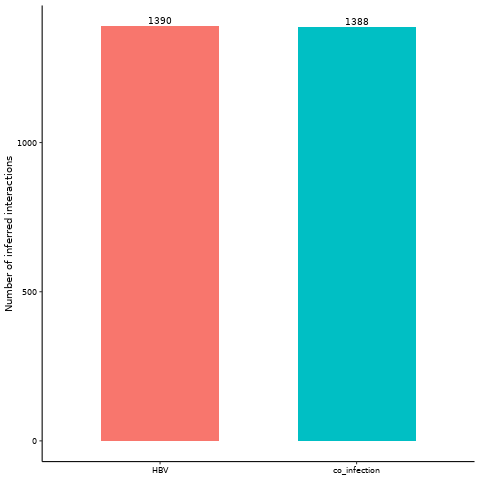

In [229]:
%%R

object.list <- list(HBV = new_cellchat_list[["HBV"]], co_infection = new_cellchat_list[["HBV_HIV"]])
cellchat <- mergeCellChat(object.list, add.names = names(object.list))

gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2))
gg1

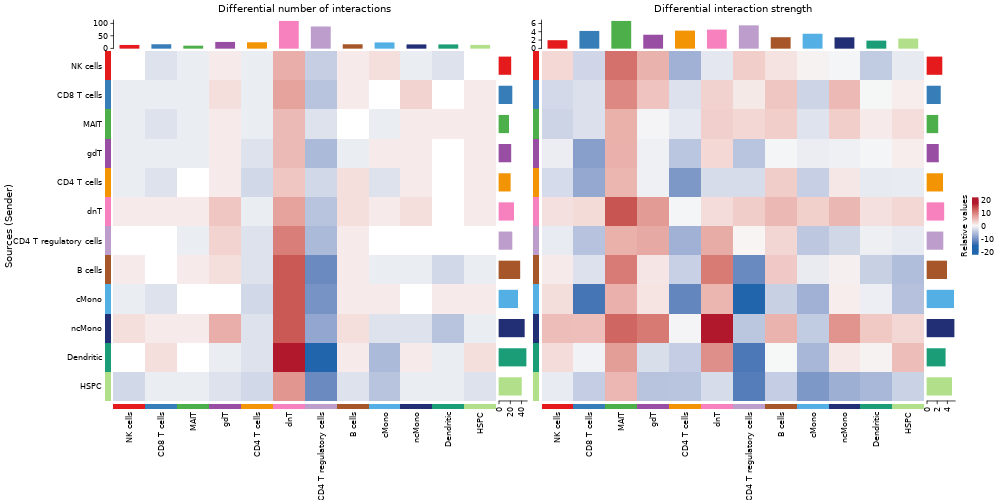

In [186]:
%%R -h 500 -w 1000
gg1 <- netVisual_heatmap(cellchat)
#> Do heatmap based on a merged object
gg2 <- netVisual_heatmap(cellchat, measure = "weight")
#> Do heatmap based on a merged object
gg1 + gg2

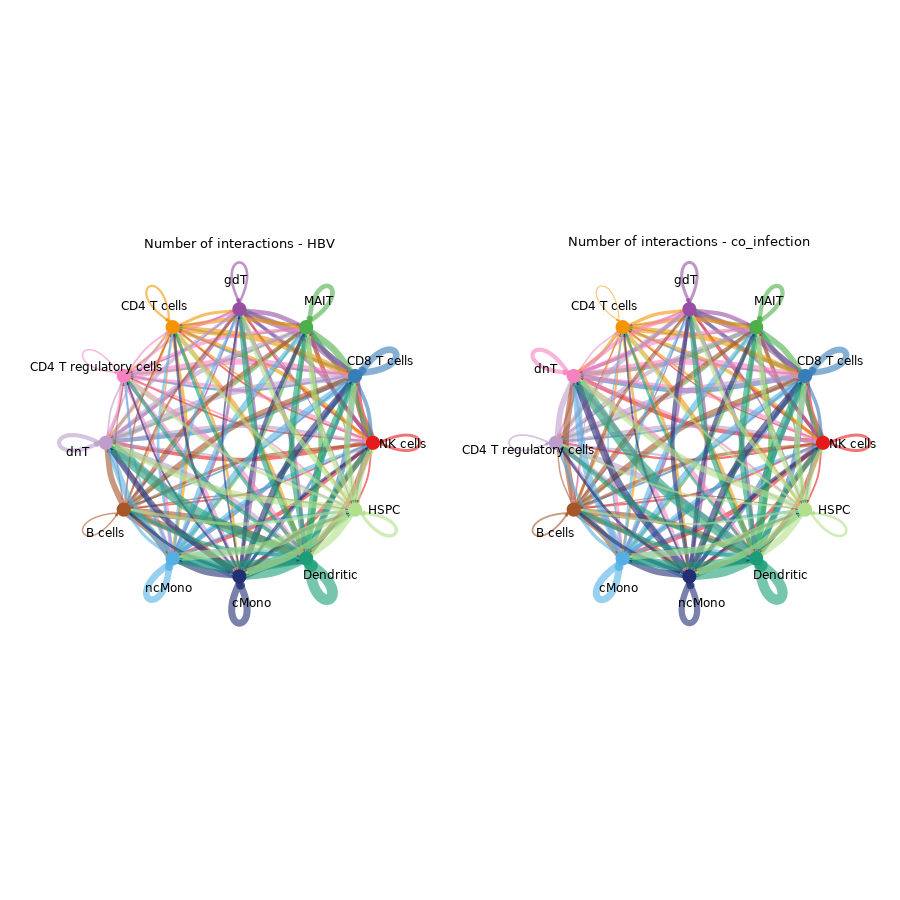

In [187]:
%%R -h 900 -w 900
weight.max <- getMaxWeight(object.list, attribute = c("idents","count"))
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_circle(object.list[[i]]@net$count, weight.scale = T, label.edge= F, edge.weight.max = weight.max[2], edge.width.max = 15, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

%%R -h 900 -w 900
group.cellType <- c(rep("MAIT", 2), rep("B cells", 2), rep("NK", 2), rep("gdT", 2), rep("ncMono", 2))
group.cellType <- factor(group.cellType, levels = c("MAIT", "B cells", "NK", "gdT","ncMono"))
object.list <- list(HBV = new_cellchat_list[["HBV"]], co_infection = new_cellchat_list[["HBV_HIV"]])

object.list <- lapply(object.list, function(x) {mergeInteractions(x, group.cellType)})

cellchat <- mergeCellChat(object.list, add.names = names(object.list))
#> Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.

weight.max <- getMaxWeight(object.list, slot.name = c("idents", "net", "net"), attribute = c("idents","count", "count.merged"))
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_circle(object.list[[i]]@net$count.merged, weight.scale = T, label.edge= T, edge.weight.max = weight.max[3], edge.width.max = 15, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

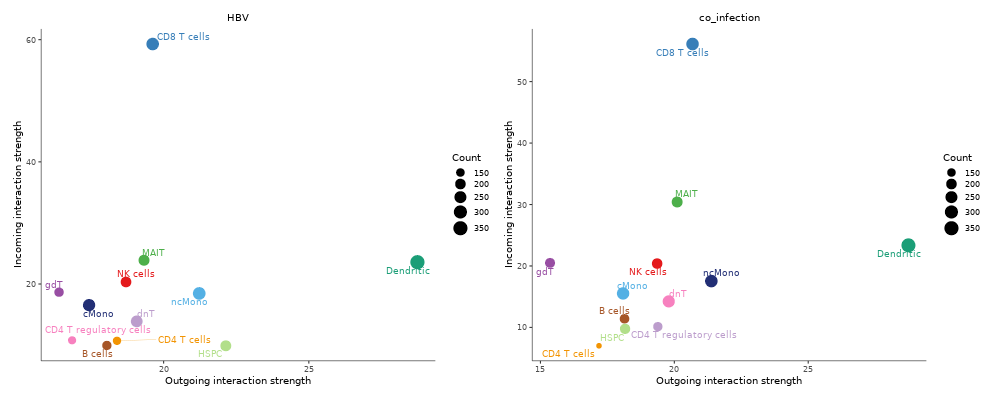

In [188]:
%%R -h 400 -w 1000
num.link <- sapply(object.list, function(x) {rowSums(x@net$count) + colSums(x@net$count)-diag(x@net$count)})
weight.MinMax <- c(min(num.link), max(num.link)) # control the dot size in the different datasets
gg <- list()
for (i in 1:length(object.list)) {
  gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]], title = names(object.list)[i], weight.MinMax = weight.MinMax)
}
#> Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
#> Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
patchwork::wrap_plots(plots = gg)

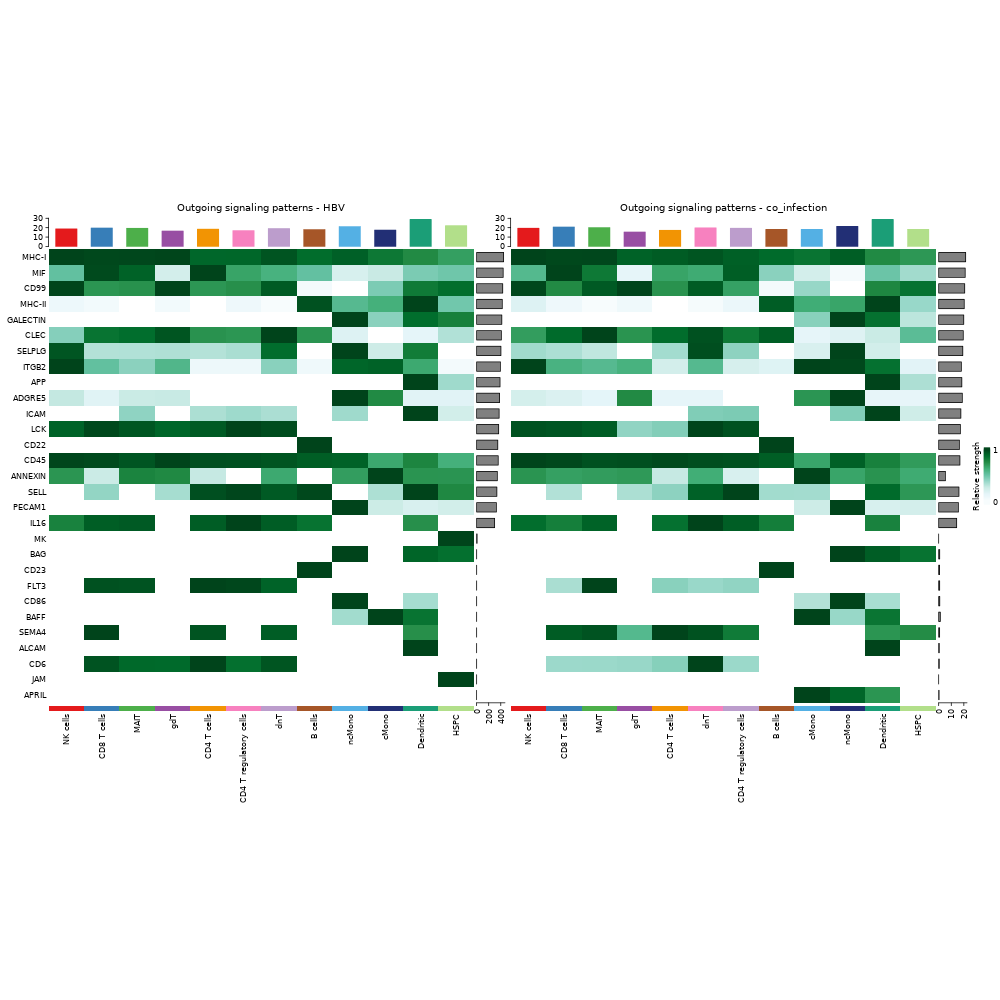

In [189]:
%%R -h 1000 -w 1000
i=1
pathway.union <- union(object.list[[i]]@netP$pathways, object.list[[i+1]]@netP$pathways)
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i], width = 15, height = 16)
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i+1], width = 15, height = 16)
ht1 + ht2


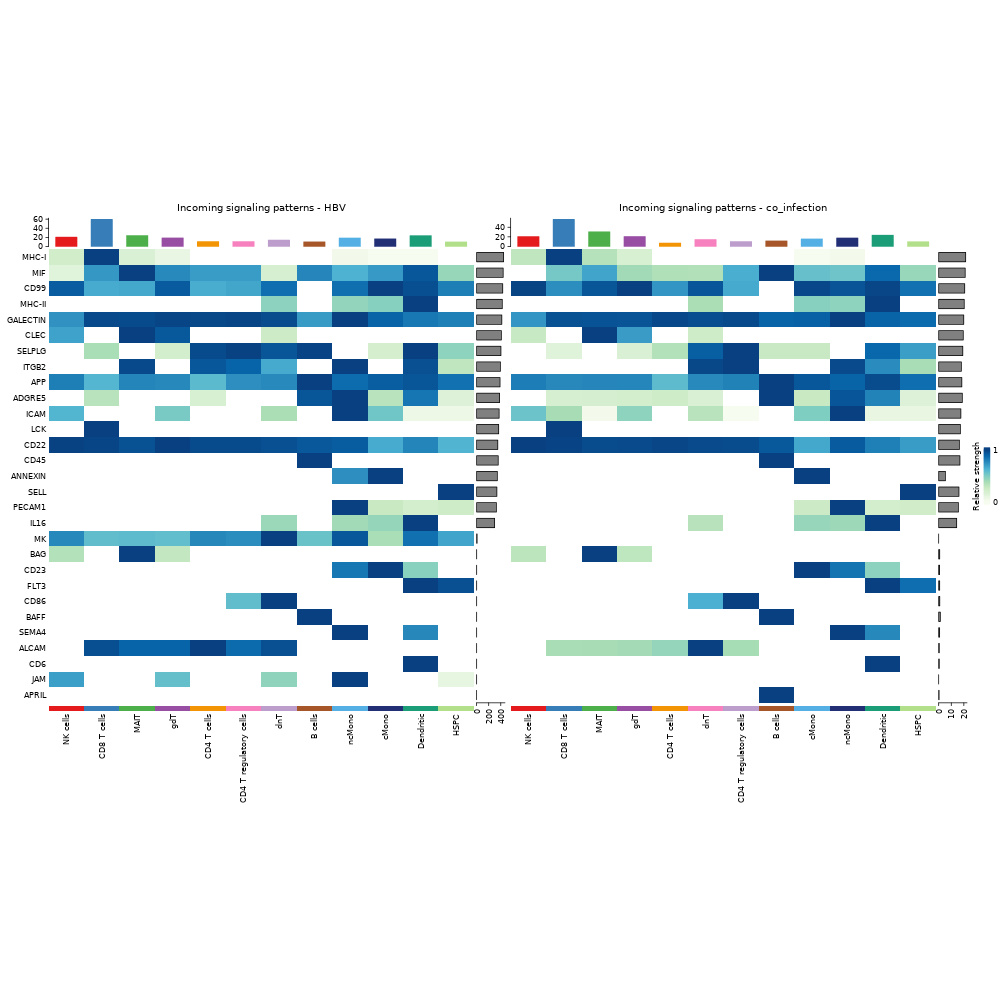

In [190]:
%%R -h 1000 -w 1000
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "incoming", signaling = pathway.union, title = names(object.list)[i], width = 15, height = 16, color.heatmap = "GnBu")
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "incoming", signaling = pathway.union, title = names(object.list)[i+1], width = 15, height = 16, color.heatmap = "GnBu")
ht1 + ht2

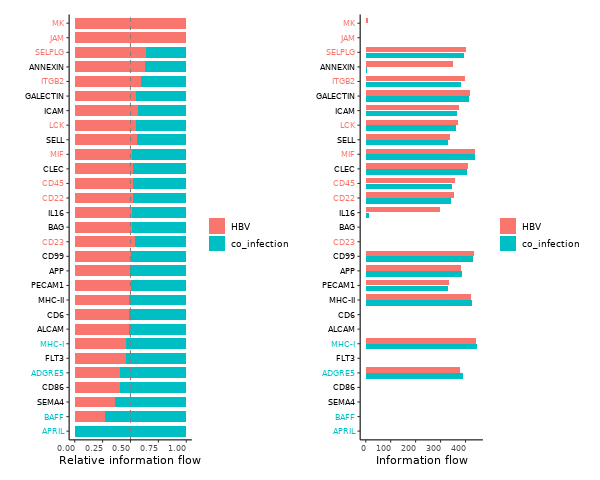

In [192]:
%%R -w 600
gg1 <- rankNet(cellchat, mode = "comparison", stacked = T, do.stat = TRUE)
gg2 <- rankNet(cellchat, mode = "comparison", stacked = F, do.stat = TRUE)
gg1 + gg2

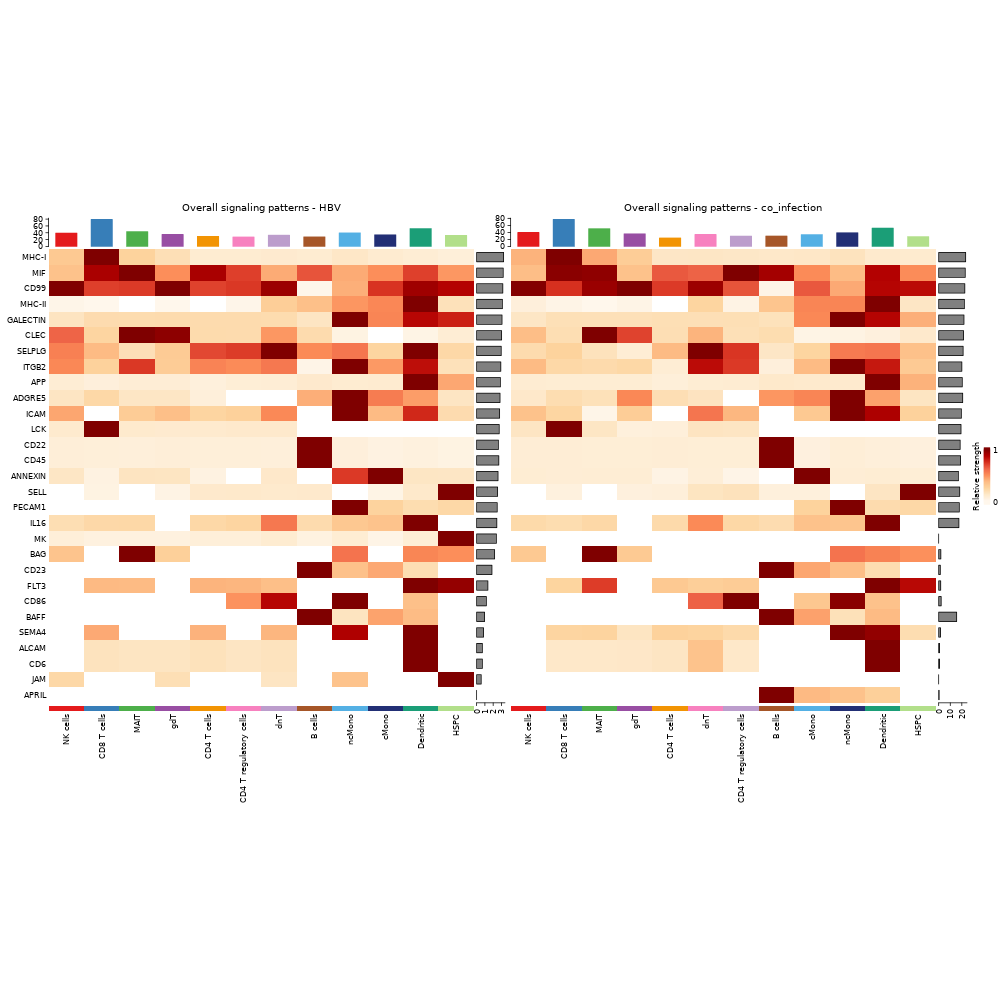

In [193]:
%%R -h 1000 -w 1000

ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "all", signaling = pathway.union, title = names(object.list)[i], width = 15, height = 16, color.heatmap = "OrRd")
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "all", signaling = pathway.union, title = names(object.list)[i+1], width = 15, height = 16, color.heatmap = "OrRd")
ht1 + ht2




In [242]:
%%R

data <- netVisual_bubble(cellchat, sources.use = 1, targets.use = c(2:20),  comparison = c(1, 2), angle.x = 45, return.data	
=T)
data[[1]]$pathway_name %>% unique()

#> Comparing communications on a merged object

 [1] "ADGRE5"  "ANNEXIN" "CD99"    "CLEC"    "MHC-I"   "MHC-II"  "IL16"   
 [8] "ITGB2"   "LCK"     "MIF"     NA        "CD45"    "SELPLG" 


  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 14% ~01s           |+++++++++                                         | 16% ~01s           |++++++++++                                        | 19% ~01s           |+++++++++++                                       | 21% ~01s           |++++++++++++                                      | 23% ~01s           |+++++++++++++                                     | 26% ~01s           |++++++++++++++                                    | 28% ~01s           |++++++++++++++++                                  | 30% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |+++                                               | 5 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 16% ~00s           |++++++++++                                        | 19% ~00s           |+++++++++++                                       | 22% ~00s           |+++++++++++++                                     | 24% ~00s           |++++++++++++++                                    | 27% ~00s           |+++++++++++++++                                   | 30% ~00s           |+++++++++++++++++                                 | 32% ~00s           |++++++++++++++++++                                | 35% ~00s 

  |                                                  | 0 % ~calculating   |++++                                              | 7 % ~00s           |++++++++                                          | 14% ~00s           |+++++++++++                                       | 21% ~00s           |+++++++++++++++                                   | 29% ~00s           |++++++++++++++++++                                | 36% ~00s           |++++++++++++++++++++++                            | 43% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |+++++++++++++++++++++++++++++                     | 57% ~00s           |+++++++++++++++++++++++++++++++++                 | 64% ~00s           |++++++++++++++++++++++++++++++++++++              | 71% ~00s           |++++++++++++++++++++++++++++++++++++++++          | 79% ~00s           |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 93% ~00s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 10% ~01s           |+++++++                                           | 12% ~01s           |++++++++                                          | 15% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 20% ~01s           |+++++++++++                                       | 22% ~01s           |+++++++++++++                                     | 24% ~01s           |++++++++++++++                                    | 27% ~01s           |+++++++++++++++                                   | 29% ~01s           |++++++++++++++++                                  | 32% ~01s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~00s           |+++                                               | 6 % ~00s           |+++++                                             | 8 % ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 14% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 19% ~00s           |++++++++++++                                      | 22% ~00s           |+++++++++++++                                     | 25% ~00s           |++++++++++++++                                    | 28% ~00s           |++++++++++++++++                                  | 31% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++                               | 36% ~00s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 7 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 15% ~00s 

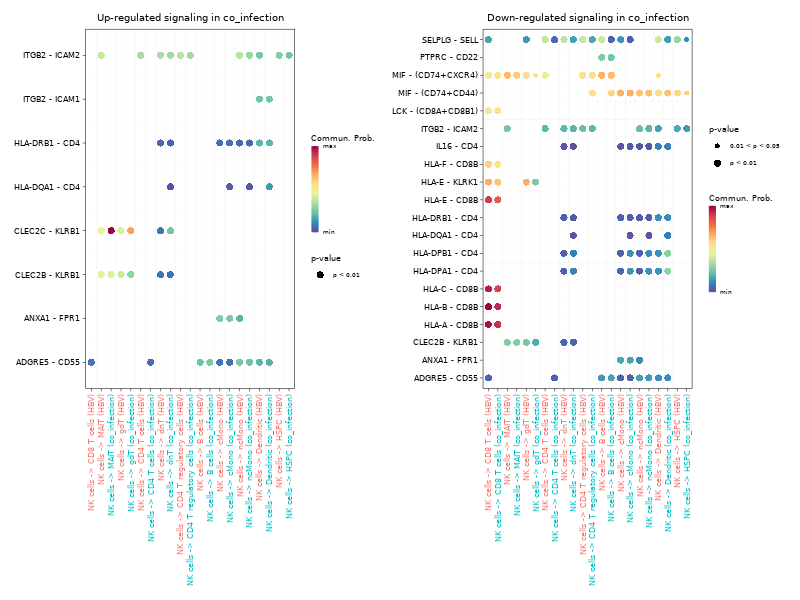

In [218]:
%%R -h 600 -w 800 
# define a positive dataset, i.e., the dataset with positive fold change against the other dataset
pos.dataset = "co_infection"
# define a char name used for storing the results of differential expression analysis
features.name = pos.dataset
# perform differential expression analysis
cellchat <- identifyOverExpressedGenes(cellchat, group.dataset = "datasets", pos.dataset = pos.dataset, features.name = features.name, only.pos = FALSE, thresh.pc = 0.1, thresh.fc = 0.1, thresh.p = 1)
#> Use the joint cell labels from the merged CellChat object
# map the results of differential expression analysis onto the inferred cell-cell communications to easily manage/subset the ligand-receptor pairs of interest
net <- netMappingDEG(cellchat, features.name = features.name)
# extract the ligand-receptor pairs with upregulated ligands in LS
net.up <- subsetCommunication(cellchat, net = net, datasets = "co_infection",ligand.logFC = 0.2, receptor.logFC = NULL)
# extract the ligand-receptor pairs with upregulated ligands and upregulated recetptors in NL, i.e.,downregulated in LS
net.down <- subsetCommunication(cellchat, net = net, datasets = "HBV",ligand.logFC = -0.1, receptor.logFC = -0.1)

gene.up <- extractGeneSubsetFromPair(net.up, cellchat)
gene.down <- extractGeneSubsetFromPair(net.down, cellchat)

pairLR.use.up = net.up[, "interaction_name", drop = F]
gg1 <- netVisual_bubble(cellchat, pairLR.use = pairLR.use.up, sources.use = 1, targets.use = c(2:20), comparison = c(1, 2),  angle.x = 90, remove.isolate = T,title.name = paste0("Up-regulated signaling in ", names(object.list)[2]))
#> Comparing communications on a merged object
pairLR.use.down = net.down[, "interaction_name", drop = F]
gg2 <- netVisual_bubble(cellchat, pairLR.use = pairLR.use.down, sources.use = 1, targets.use = c(2:20), comparison = c(1, 2),  angle.x = 90, remove.isolate = T,title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))
#> Comparing communications on a merged object
gg1 + gg2

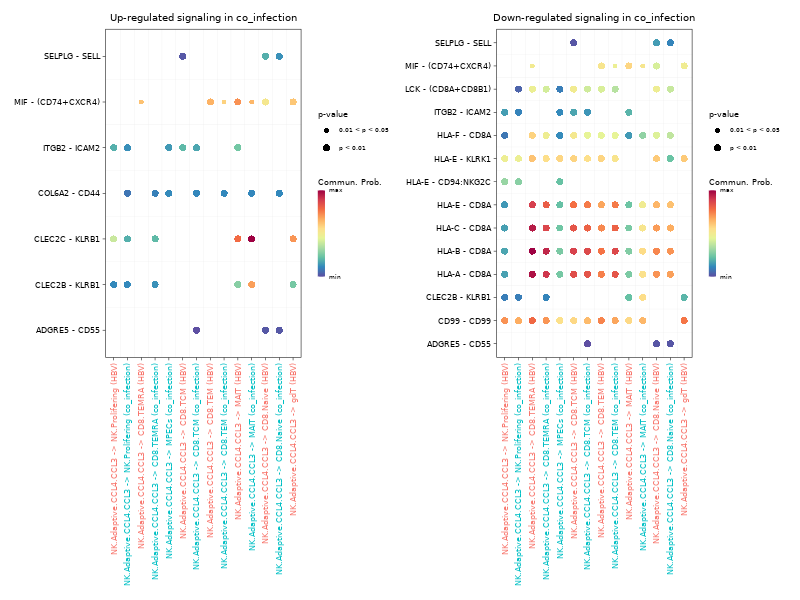

In [120]:
%%R -h 600 -w 800 
gg1 <- netVisual_bubble(cellchat, pairLR.use = pairLR.use.up, sources.use = 4, targets.use = c(5:11), comparison = c(1, 2),  angle.x = 90, remove.isolate = T,title.name = paste0("Up-regulated signaling in ", names(object.list)[2]))
#> Comparing communications on a merged object
pairLR.use.down = net.down[, "interaction_name", drop = F]
gg2 <- netVisual_bubble(cellchat, pairLR.use = pairLR.use.down, sources.use = 4, targets.use = c(5:11), comparison = c(1, 2),  angle.x = 90, remove.isolate = T,title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))
#> Comparing communications on a merged object
gg1 + gg2

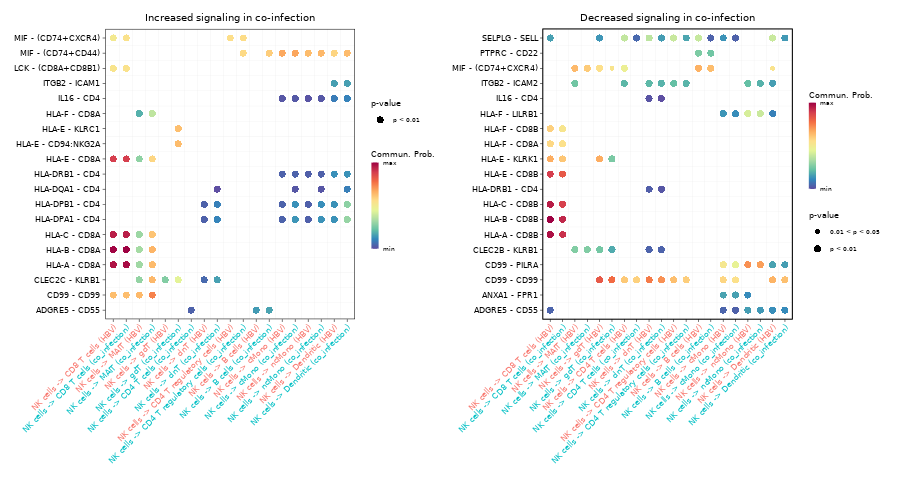

In [224]:
%%R -w 900
gg1 <- netVisual_bubble(cellchat, sources.use = 1, targets.use = c(2:11),  comparison = c(1, 2), max.dataset = 2, title.name = "Increased signaling in co-infection", angle.x = 45, remove.isolate = T)
#> Comparing communications on a merged object
gg2 <- netVisual_bubble(cellchat, sources.use = 1, targets.use = c(2:11),  comparison = c(1, 2), max.dataset = 1, title.name = "Decreased signaling in co-infection", angle.x = 45, remove.isolate = T)
#> Comparing communications on a merged object
gg1 + gg2

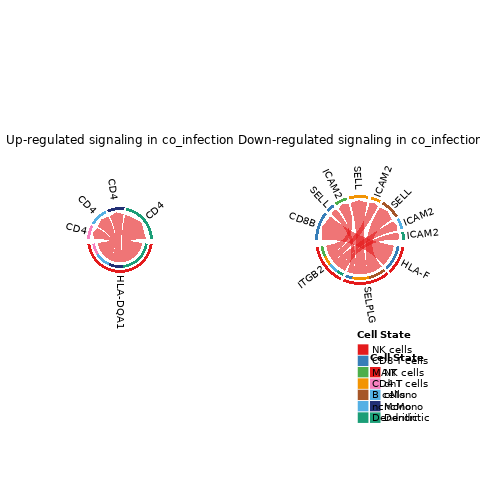

In [227]:
%%R
# Chord diagram
par(mfrow = c(1,2), xpd=TRUE)
netVisual_chord_gene(object.list[[2]], sources.use = 1, targets.use = c(2:20), slot.name = 'net', net = net.up, lab.cex = 0.8, small.gap = 3.5, title.name = paste0("Up-regulated signaling in ", names(object.list)[2]))
netVisual_chord_gene(object.list[[1]], sources.use = 1, targets.use = c(2:20), slot.name = 'net', net = net.down, lab.cex = 0.8, small.gap = 3.5, title.name = paste0("Down-regulated signaling in ", names(object.list)[2]))

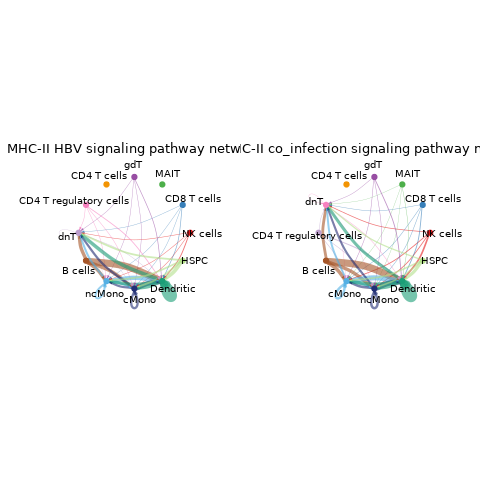

In [245]:
%%R
pathways.show <- c("MHC-II") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,2), xpd=TRUE)

for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], signaling = pathways.show, layout = "circle", edge.weight.max = weight.max[1], edge.width.max = 10, signaling.name = paste(pathways.show, names(object.list)[i]))
}

In [125]:
%%R

exhaustion <- list(c("TOX", "HAVCR2", "LAG3", "LAYN", "PDCD1", "TIGIT"))

peppa <- AddModuleScore(
  object = peppa,
  features = exhaustion,
  ctrl = 6,
  name = 'Exhaustion_score_new'
)




In [126]:
%%R
head(peppa@meta.data)

                               orig.ident nCount_RNA nFeature_RNA sample_ID
AAACCTGTCGCATGGC-1-HIVHBV_C SeuratProject   2508.859         1259  HIVHBV_C
AAACGGGAGATATACG-1-HIVHBV_C SeuratProject   2921.987         2053  HIVHBV_C
AAACGGGAGTTACCCA-1-HIVHBV_C SeuratProject   2819.482         2175  HIVHBV_C
AAACGGGCATCGGTTA-1-HIVHBV_C SeuratProject   2773.429         1649  HIVHBV_C
AAAGATGTCTCGCTTG-1-HIVHBV_C SeuratProject   2699.850         1657  HIVHBV_C
AAAGCAAAGCGTTCCG-1-HIVHBV_C SeuratProject   2513.127         1455  HIVHBV_C
                            nCount_HTO nFeature_HTO HTO_maxID HTO_secondID
AAACCTGTCGCATGGC-1-HIVHBV_C        260            2 Hashtag-2    Hashtag-1
AAACGGGAGATATACG-1-HIVHBV_C        733            2 Hashtag-2    Hashtag-1
AAACGGGAGTTACCCA-1-HIVHBV_C        570            2 Hashtag-2    Hashtag-1
AAACGGGCATCGGTTA-1-HIVHBV_C       1193            2 Hashtag-2    Hashtag-1
AAAGATGTCTCGCTTG-1-HIVHBV_C       3162            2 Hashtag-1    Hashtag-2
AAAGCAAAGCGTTCCG-1

AAACCTGTCGCATGGC-1-HIVHBV_C        <NA>        <NA>        NaN          NaN
AAACGGGAGATATACG-1-HIVHBV_C        <NA>        <NA>        NaN          NaN
AAACGGGAGTTACCCA-1-HIVHBV_C        <NA>        <NA>        NaN          NaN
AAACGGGCATCGGTTA-1-HIVHBV_C        <NA>        <NA>        NaN          NaN
AAAGATGTCTCGCTTG-1-HIVHBV_C        <NA>        <NA>        NaN          NaN
AAAGCAAAGCGTTCCG-1-HIVHBV_C        <NA>        <NA>        NaN          NaN
                            X_index n_genes_by_counts total_counts
AAACCTGTCGCATGGC-1-HIVHBV_C    <NA>               NaN          NaN
AAACGGGAGATATACG-1-HIVHBV_C    <NA>               NaN          NaN
AAACGGGAGTTACCCA-1-HIVHBV_C    <NA>               NaN          NaN
AAACGGGCATCGGTTA-1-HIVHBV_C    <NA>               NaN          NaN
AAAGATGTCTCGCTTG-1-HIVHBV_C    <NA>               NaN          NaN
AAAGCAAAGCGTTCCG-1-HIVHBV_C    <NA>               NaN          NaN
                            total_counts_mt pct_counts_mt
AAACCTGTCGCATGGC-

`summarise()` has grouped output by 'celltype_consensus.l2', 'bio_replicate'. You can override using the `.groups` argument.


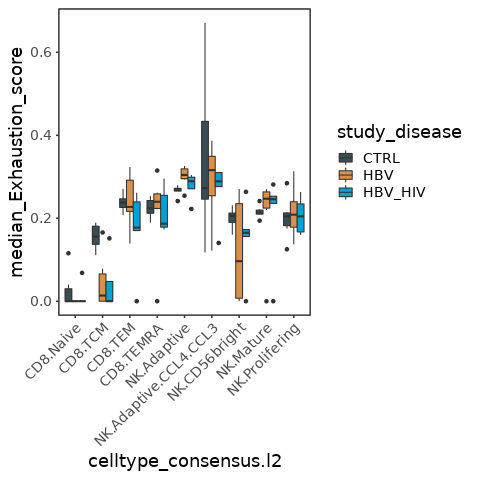

In [133]:
%%R
Idents(peppa) <- "celltype_consensus.l2"

peppa@meta.data %>%
select(Exhaustion_score_new1, celltype_consensus.l2, bio_replicate,study_disease) %>%
filter(grepl("CD8|NK", celltype_consensus.l2)) %>%
filter(Exhaustion_score_new1 >=0) %>%
group_by(celltype_consensus.l2, bio_replicate, study_disease) %>% 
summarise(median_Exhaustion_score = median(Exhaustion_score_new1, na.rm = TRUE)) %>%

ggplot(aes(celltype_consensus.l2, median_Exhaustion_score, fill = study_disease))+
geom_boxplot(position = "dodge")+
theme(axis.text.x = element_text(angle=45, hjust=1))+
ggsci::scale_fill_jama()


In [135]:
%%R




Error in library(msigdbr) : there is no package called 'msigdbr'


RInterpreterError: Failed to parse and evaluate line '\n##clusterprofiler\nlibrary(msigdbr)\nlibrary("org.Hs.eg.db")\nlibrary("AnnotationHub")\n\n\nlibrary(msigdbr)\nlibrary(ReactomePA)\n#reactomedb <- ReactomePA:::getDb("human")\n#head(reactomedb)\nm_df <- msigdbr(species = "human")\nhead(m_df)\nm_df %>%\n  filter(grepl("GSE41867|GSE9650", gs_name)) %>%\n  dplyr::select(gs_name) %>%\n  unique() %>%\n  as.data.frame()\n\nGSE41867|GSE9650\nm_t2g <- msigdbr(species = "Homo sapiens", category = "C2", subcategory = "REACTOME") %>% \n  dplyr::select(gs_name, gene_symbol) \n\nm_t2g_immune <- msigdbr(species = "Homo sapiens", category = "C7", subcategory = "IMMUNESIGDB")  %>% \n  dplyr::select(gs_name, gene_symbol)\n\nm_kegg <- msigdbr(species = "Homo sapiens", category = "C2", subcategory = "REACTOME") %>% \n  dplyr::select(gs_name, gene_symbol) \n\n\n\nlibrary(fgsea)\n\nfgsea_sets<- m_t2g_immune %>% split(x = .$gene_symbol, f = .$gs_name)\n\n\nfgsea_sets$pathway[grepl("EXH", fgsea_sets$pathway)]\n\nmodule_score_exhaust <- fgsea_sets %>%\n  filter(grepl("EXH", pathway)) %>% \n    filter(grepl("GSE9650_EFF", pathway)) %>%\n  as.data.frame()\n\n'.
R error message: "Error in library(msigdbr) : there is no package called 'msigdbr'"